# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [2]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 27.58 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Dict, Optional
from pathlib import Path
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [4]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

In [5]:
# ImageNet mean and std for normalization
IMG_SIZE = (224, 224) # A common size for image classification tasks
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)), # Increased the lower bound of the scale
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Create Dataset instances
train_dataset = OxfordPetDataset(split="train", transform=train_transform)
val_dataset = OxfordPetDataset(split="val", transform=val_test_transform)
test_dataset = OxfordPetDataset(split="test", transform=val_test_transform)

# Create DataLoader instances
BATCH_SIZE = 128 # You can tune this hyperparameter

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Get number of classes
NUM_CLASSES = train_dataset.get_num_classes()
INPUT_DIM = len(train_dataset[0][0])
print(f"Number of classes: {NUM_CLASSES}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Number of classes: 37
Training samples: 3669
Validation samples: 1834
Test samples: 1846


In [6]:
# Check for CUDA availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

Using device: cuda


In [7]:
class VGGLikeModel(nn.Module):
    def __init__(self, num_classes: int, input_channels: int, cfg: list):
        super().__init__()

        layers = []
        in_channels = input_channels
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif v == '1': # 1x1 convolution
                conv2d = nn.Conv2d(in_channels, in_channels, kernel_size=1)
                layers += [conv2d, nn.BatchNorm2d(in_channels), nn.ReLU(inplace=True)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                in_channels = v

        self.features = nn.Sequential(*layers)

        # Determine the output size of the convolutional layers
        self._feature_output_size = self._get_conv_output_size(IMG_SIZE)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._feature_output_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def _get_conv_output_size(self, img_size):
        with torch.no_grad():
            dummy_input = torch.zeros(1, INPUT_DIM, img_size[0], img_size[1])
            output = self.features(dummy_input)
            return int(np.prod(output.size()))


    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [8]:
def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                criterion: nn.Module,
                optimizer: optim.Optimizer,
                device: torch.device,
                scheduler: Optional[lr_scheduler.LRScheduler] = None) -> Tuple[float, float]:
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    avg_loss = epoch_loss / total_samples
    avg_acc = correct_predictions.double() / total_samples
    return avg_loss, avg_acc.item()

def evaluate_model(model: nn.Module,
                   dataloader: DataLoader,
                   criterion: nn.Module,
                   device: torch.device) -> Tuple[float, float]:
    model.eval()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    avg_loss = epoch_loss / total_samples
    avg_acc = correct_predictions.double() / total_samples
    return avg_loss, avg_acc.item()

def plot_history(history: Dict[str, List[float]]):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
vgg_config = {
    "experiment_name": "VGG-like_Smaller",
    "cfg": [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # VGG-11 like configuration with 1x1 conv removed
    "lr": 1e-3,
    "weight_decay": 1e-3,
    "use_scheduler": True
}

# Instantiate the model with the VGG-like configuration
model_summary = VGGLikeModel(input_channels=INPUT_DIM,
                             num_classes=NUM_CLASSES,
                             cfg=vgg_config['cfg']
                            ).to(DEVICE)

# Display the model summary
summary(model_summary, (INPUT_DIM, IMG_SIZE[0], IMG_SIZE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1, 256,

In [11]:
EPOCHS = 200
HIDDEN_DIM = 64

def run_experiment(config: Dict, model = None):
    print("="*60 + f"\nStart running the model: {config['experiment_name']}\n" + "="*60)
    fix_random(42)

    if model is None:
        model = VGGLikeModel(input_channels=INPUT_DIM,
                             num_classes=NUM_CLASSES,
                             cfg=config['cfg']
                            ).to(DEVICE)

    # Setup of Early stopping, LR schedule and weight decay
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.get("lr", 1e-3), weight_decay=config['weight_decay'])
    if config['use_scheduler']:
        warmup_scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=5)
        main_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=15)

    # Training Loop
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    pbar = tqdm(range(EPOCHS), desc=f"Training {config['experiment_name']}")
    for epoch in pbar:
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        if config['use_scheduler']:
            if epoch < 5: warmup_scheduler.step()
            else: main_scheduler.step(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{config['experiment_name']}.pt")
            #print(f"Saved new best model, val acc: {val_acc}")
        pbar.set_postfix({"Val Acc": f"{val_acc:.4f}", "Train Acc": f"{train_acc:.4f}"})

    # Final test and save result
    sd = torch.load(f"{config['experiment_name']}.pt")
    model.load_state_dict(sd)
    _, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f"Model '{config['experiment_name']}' completed. Test Accuracy: {test_acc:.4f}\n")

    result = config.copy()
    result.update({'test_accuracy': test_acc, 'best_val_accuracy': best_val_acc, 'history': history})
    return result

In [12]:
def plot_key_histories_acc(df, experiments_to_plot, title):
    plt.figure(figsize=(14, 8))
    for name in experiments_to_plot:
        row = df[df['experiment_name'] == name]
        if row.empty: continue
        history = row.iloc[0]['history']
        plt.plot(history['val_acc'], label=name+" val", lw=2)
        plt.plot(history['train_acc'], label=name+" train", lw=2)

    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Epochs', fontsize=12); plt.ylabel('Accuracy', fontsize=12)
    plt.legend(); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0); plt.show()

def plot_key_histories_loss(df, experiments_to_plot, title):
    plt.figure(figsize=(14, 8))
    for name in experiments_to_plot:
        row = df[df['experiment_name'] == name]
        if row.empty: continue
        history = row.iloc[0]['history']
        plt.plot(history['val_loss'], label=name+" val", lw=2)
        plt.plot(history['train_loss'], label=name+" train", lw=2)

    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Epochs', fontsize=12); plt.ylabel('Loss', fontsize=12)
    plt.legend(); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0); plt.show()

### Final model

In [13]:
# Configuration for a smaller VGG-like model (similar to VGG11-like)
vgg_config = {
    "experiment_name": "VGG-like_Smaller",
    "cfg": [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # VGG-11 like configuration with 1x1 conv removed
    "lr": 1e-3,
    "weight_decay": 1e-3,
    "use_scheduler": True
}

vgg_results = run_experiment(vgg_config)

Start running the model: VGG-like_Smaller


Training VGG-like_Smaller:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

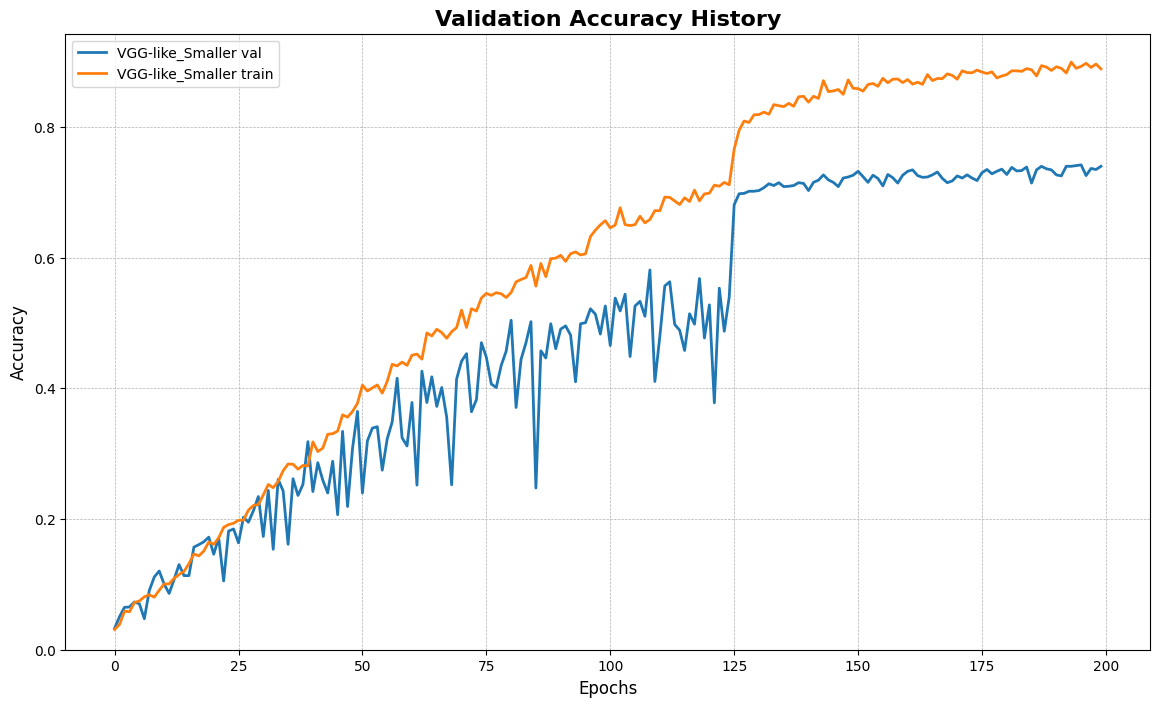

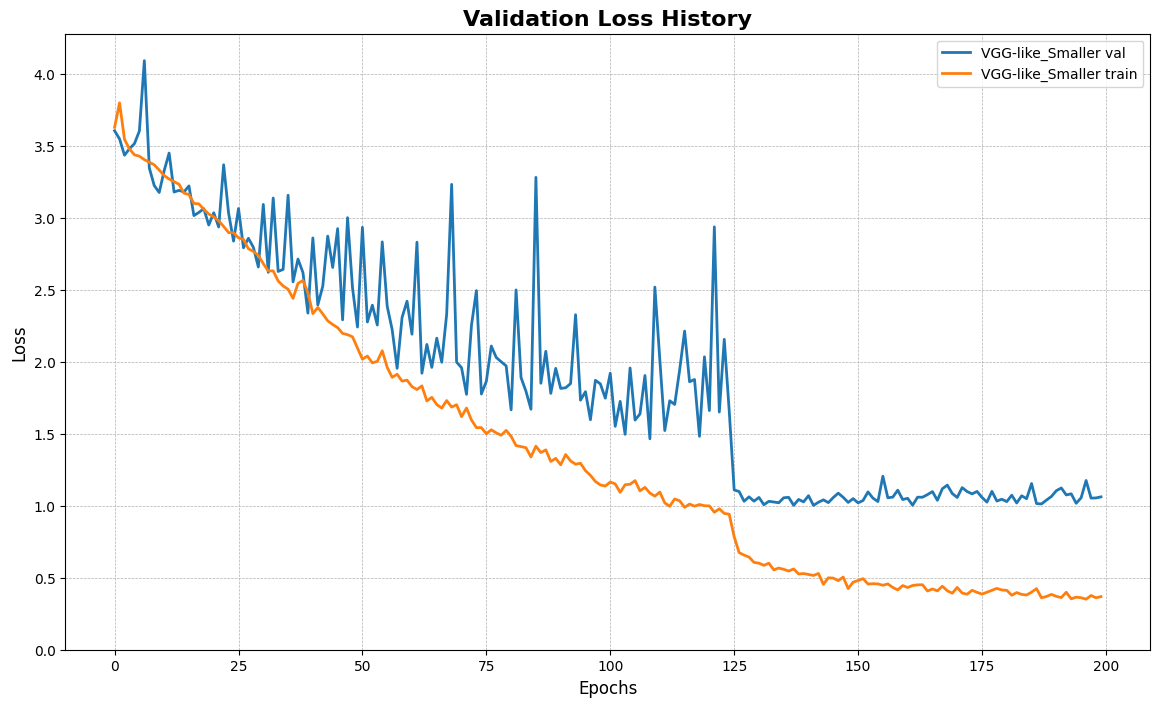

In [ ]:
# Assuming vgg_results is a list of results, or you want to plot a single result
# If vgg_results is a single dictionary:
results_df = pd.DataFrame([vgg_results])

# If vgg_results is a list of dictionaries:
# results_df = pd.DataFrame(vgg_results)


plot_key_histories_acc(results_df, ['VGG-like_Smaller'], 'Validation Accuracy History')
plot_key_histories_loss(results_df, ['VGG-like_Smaller'], 'Validation Loss History')

In [ ]:
import pickle

# Assuming vgg_results contains the history dictionary
if 'history' in vgg_results:
    with open(f"{vgg_results['experiment_name']}_history.pkl", 'wb') as f:
        pickle.dump(vgg_results['history'], f)
    print(f"Training history for {vgg_results['experiment_name']} saved as {vgg_results['experiment_name']}_history.pkl")
else:
    print("History not found in vgg_results.")

Training history for VGG-like_Smaller saved as VGG-like_Smaller_history.pkl


In [ ]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the saved model weights
model_path = f"{vgg_results['experiment_name']}.pt"
history_path = f"{vgg_results['experiment_name']}_history.pkl"


# Define the destination path in your Google Drive
# You can change 'My Drive/model_weights' to your desired folder path
drive_path = '/content/drive/My Drive/model_weights'
os.makedirs(drive_path, exist_ok=True) # Create the directory if it doesn't exist

# Copy the model weights to Google Drive
shutil.copy(model_path, drive_path)

# Copy the history pickle file to Google Drive
shutil.copy(history_path, drive_path)


print(f"Model weights saved to {drive_path}/{vgg_results['experiment_name']}.pt")
print(f"Training history saved to {drive_path}/{vgg_results['experiment_name']}_history.pkl")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model weights saved to /content/drive/My Drive/model_weights/VGG-like_Smaller.pt
Training history saved to /content/drive/My Drive/model_weights/VGG-like_Smaller_history.pkl
